## Introduction

In [1]:
!pygmentize helper_scripts/lda.py

from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (22, 10)
plt.style.use("seaborn-whitegrid")


class LDA:
    def __init__(self, training_samples):
        self.texts = training_samples
        self.docs = [data.split() for data in self.texts]
        self.dictionary = corpora.Dictionary(self.docs)
        self.bow_corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]

    def __iter__(self):
        self.length = len(self.texts)
        self.n = 0
        return self

    def __next__(self):
        token = self.bow_corpus[self.n]
        self.n += 1
        if self.n == self.length:
            self.n == 1
        return [(self.dictionary[ii], freq) for ii, freq in token]

    def filter_extremes(self, keep_n, no_below, no_above):
        self.dictionary.filter_extremes(
            keep_n=keep_n, no_below=no_below,

## Jupyter Notebook Setup

In [2]:
%load_ext autoreload
%autoreload 2

from helper_scripts import lda
import os
import pickle
import re
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setup before git push.
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
# pio.renderers.default = 'iframe' # for localhost
pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [4]:
df = pd.read_parquet('../cleaned_data/cleaned_reviews.parquet.gzip')
df.head()

title       date location  \
0  Which iPhone you should Purchase ? iPhone 8, X... 2018-12-12    India   
1                   Don't buy iPhone xr from Amazon. 2018-11-17    India   
2                            Happy with the purchase 2019-01-27    India   
3  Amazon is not an apple authorised reseller. Pl... 2019-05-02    India   
4       Excellent Battery life and buttery smooth UI 2019-05-24    India   

   rating                                               text  \
0     3.0  NOTE:@ This is detailed comparison between iPh...   
1     1.0  Very bad experience with this iPhone xr phone....   
2     5.0  Amazing phone with amazing camera coming from ...   
3     1.0  So I got the iPhone XR just today. The product...   
4     5.0  I've been an android user all my life until I ...   

                     title_clean  \
0  iphon purchas iphon 8 x xs xr   
1      don t buy iphon xr amazon   
2                        purchas   
3         amazon appl resel note   
4  excel batteri life butteri ui   

                                          text_clean  
0  note comparison iphon 8 x xs xr month state ba...  
1  experi iphon xr camera find amazon haven t get...  
2             camera come iphon 7 plus servic amazon  
3  get iphon xr today product look face d work gl...  
4  ve android user life decid tri iphon xr io lov...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        3277 non-null   object        
 1   date         3277 non-null   datetime64[ns]
 2   location     3277 non-null   object        
 3   rating       3277 non-null   float32       
 4   text         3277 non-null   object        
 5   title_clean  3277 non-null   object        
 6   text_clean   3277 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(5)
memory usage: 166.5+ KB


## LDA

### Initializing the model

In [6]:
lda_model = lda.LDA(df['text_clean'])

In [7]:
# sanity check on data
it = iter(lda_model)
it = next(it)
it.insert(0, ('word', 'frequency'))
it[:30]

[('word', 'frequency'),
 ('1', 1),
 ('11', 1),
 ('12', 1),
 ('14', 1),
 ('15', 1),
 ('16', 1),
 ('18', 1),
 ('20', 1),
 ('4', 3),
 ('4k', 1),
 ('5', 1),
 ('6', 3),
 ('64', 1),
 ('7', 2),
 ('75kxr', 1),
 ('77kxs', 1),
 ('8', 19),
 ('80k', 1),
 ('9', 1),
 ('99k', 1),
 ('accord', 1),
 ('aluminum', 1),
 ('appear', 1),
 ('batteri', 4),
 ('bodi', 1),
 ('budget', 2),
 ('build', 1),
 ('button', 1),
 ('camera', 3)]

In [8]:
lda_model = lda.LDA(df['text_clean'])
lda_model.filter_extremes(keep_n=10000, no_below=10,  no_above = 0.3)
# sanity check on dictionary size
len(lda_model.dictionary)

417

### Training & evaluating the model

In [38]:
lda_model.fit(3)
## Evaluate the model
lda_model.print_output()

Topic: 0	Coherence Score: 0.6077
Words: 0.060*"iphon" + 0.034*"xr" + 0.031*"price" + 0.027*"qualiti" + 0.027*"camera" + 0.020*"appl" + 0.019*"product" + 0.017*"batteri" + 0.015*"use" + 0.015*"featur"

########

Topic: 1	Coherence Score: 0.3773
Words: 0.098*"product" + 0.037*"amazon" + 0.034*"buy" + 0.030*"love" + 0.027*"money" + 0.024*"iphon" + 0.023*"appl" + 0.022*"mobil" + 0.021*"like" + 0.019*"valu"

########

Topic: 2	Coherence Score: 0.4975
Words: 0.076*"batteri" + 0.047*"life" + 0.046*"camera" + 0.039*"iphon" + 0.028*"appl" + 0.023*"qualiti" + 0.020*"work" + 0.018*"product" + 0.016*"day" + 0.015*"perform"

########

Perplexity Score: -5.5061 
Overall Coherence Score: 0.4942


In [39]:
lda_model.score(df.sample(500)['text_clean'].apply(lambda x: x.split()), return_per_topic=True)

(0.30775919697028237,
 [0.28933466804852415, 0.3201196946718877, 0.3138232281904353])

### Visualizing training results

In [40]:
lda_model.visualize_topics_

### Hyperparameter tuning

tuning: 100%|██████████| 59/59 [08:47<00:00,  8.95s/it, max_coherence_score=0.495, best_params={'num_topics': 8, 'alpha': 'symmetric', 'beta': 'symmetric'}]


Finished hyperparameter tuning, model updated!


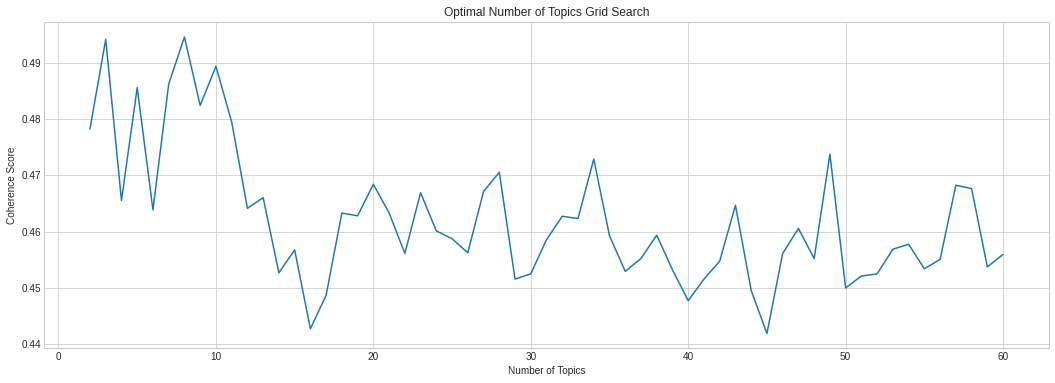

In [12]:
lda_model.find_best_num_topics()

In [15]:
num_topic_range = range(2, 11)
alpha_range = list(np.arange(0.0, 1.01, 0.1))
alpha_range.append("symmetric")
alpha_range.append("asymmetric")
beta_range = list(np.arange(0.0, 1.01, 0.1))
beta_range.append("symmetric")

lda_model.tune(num_topic_range=num_topic_range, alpha_range=alpha_range, beta_range=beta_range)

tuning: 100%|██████████| 1404/1404 [2:55:19<00:00,  7.49s/it, max_coherence_score=0.517, best_params={'num_topics': 7, 'alpha': 'asymmetric', 'beta': 0.8}]                       


Finished hyperparameter tuning, model updated!


In [16]:
path = "../app/models"
if not os.path.exists(path):
    os.makedirs(path)
    
with open(os.path.join(path, 'lda_model.sav'), 'wb') as f:
    pickle.dump(lda_model, f)

## LDA Result & Post Modeling Analysis

In [42]:
lda_model.fit(**lda_model.best_params_, predict_training_samples=True)

lda_model.print_output()

Topic: 0	Coherence Score: 0.4498
Words: 0.103*"product" + 0.060*"iphon" + 0.037*"appl" + 0.037*"price" + 0.035*"batteri" + 0.031*"camera" + 0.029*"qualiti" + 0.022*"xr" + 0.017*"life" + 0.015*"superb"

########

Topic: 1	Coherence Score: 0.3734
Words: 0.059*"product" + 0.059*"amazon" + 0.052*"love" + 0.049*"buy" + 0.047*"money" + 0.033*"valu" + 0.027*"mobil" + 0.026*"thank" + 0.017*"experi" + 0.016*"iphon"

########

Topic: 2	Coherence Score: 0.5568
Words: 0.121*"batteri" + 0.085*"life" + 0.048*"camera" + 0.028*"work" + 0.025*"face" + 0.022*"qualiti" + 0.020*"iphon" + 0.015*"display" + 0.013*"d" + 0.013*"perform"

########

Topic: 3	Coherence Score: 0.6137
Words: 0.042*"👍" + 0.032*"appl" + 0.023*"iphon" + 0.023*"👌" + 0.021*"android" + 0.019*"io" + 0.018*"user" + 0.018*"like" + 0.015*"batteri" + 0.013*"time"

########

Topic: 4	Coherence Score: 0.5056
Words: 0.055*"camera" + 0.041*"iphon" + 0.036*"qualiti" + 0.031*"xr" + 0.018*"batteri" + 0.017*"screen" + 0.016*"get" + 0.016*"buy" + 0.0

In [49]:
topic_names = [
    "Apple/iPhone's product pricing, battery, camera, and quality", #
    "Amazon's Product? (Unclear)",
    "Battery life, camera, quality, display", #
    "Satisfaction of switching from android to iPhone", #
    "iPhone XR's camera, battery, screen, quality, etc.", #
    "Something about iPhone and/or Amazon (Unclear)", #
    "Comparing iPhone With other phones and/or very detailed reviews" #
]


topics = '''
Topic: 0	Coherence Score: 0.4498
Words: 0.103*"product" + 0.060*"iphon" + 0.037*"appl" + 0.037*"price" + 0.035*"batteri" + 0.031*"camera" + 0.029*"qualiti" + 0.022*"xr" + 0.017*"life" + 0.015*"superb"

########

Topic: 1	Coherence Score: 0.3734
Words: 0.059*"product" + 0.059*"amazon" + 0.052*"love" + 0.049*"buy" + 0.047*"money" + 0.033*"valu" + 0.027*"mobil" + 0.026*"thank" + 0.017*"experi" + 0.016*"iphon"

########

Topic: 2	Coherence Score: 0.5568
Words: 0.121*"batteri" + 0.085*"life" + 0.048*"camera" + 0.028*"work" + 0.025*"face" + 0.022*"qualiti" + 0.020*"iphon" + 0.015*"display" + 0.013*"d" + 0.013*"perform"

########

Topic: 3	Coherence Score: 0.6137
Words: 0.042*"👍" + 0.032*"appl" + 0.023*"iphon" + 0.023*"👌" + 0.021*"android" + 0.019*"io" + 0.018*"user" + 0.018*"like" + 0.015*"batteri" + 0.013*"time"

########

Topic: 4	Coherence Score: 0.5056
Words: 0.055*"camera" + 0.041*"iphon" + 0.036*"qualiti" + 0.031*"xr" + 0.018*"batteri" + 0.017*"screen" + 0.016*"get" + 0.016*"buy" + 0.015*"work" + 0.015*"appl"

########

Topic: 5	Coherence Score: 0.3642
Words: 0.039*"s" + 0.032*"️" + 0.031*"expect" + 0.030*"appl" + 0.028*"iphon" + 0.023*"deliveri" + 0.022*"❤" + 0.021*"time" + 0.018*"amazon" + 0.015*"like"

########

Topic: 6	Coherence Score: 0.7580
Words: 0.048*"iphon" + 0.021*"t" + 0.020*"xr" + 0.016*"face" + 0.014*"3" + 0.014*"appl" + 0.014*"day" + 0.014*"7" + 0.013*"6" + 0.013*"2"
'''

topics = re.findall('(Topic: \d|Words:.*)', topics)

assert len(topics) / 2 == len(topic_names), "Number of given names doesn't match number of topics!"

topics = {k:', '.join(re.findall('"\w+"', topics[i + 1])) for k, i in zip(topic_names, range(0, len(topics), 2))}

for k, v in topics.items():
    print('topic:', k)
    print('words:', v, end='\n*****\n\n')

topic: Apple/iPhone's product pricing, battery, camera, and quality
words: "product", "iphon", "appl", "price", "batteri", "camera", "qualiti", "xr", "life", "superb"
*****

topic: Amazon's Product? (Unclear)
words: "product", "amazon", "love", "buy", "money", "valu", "mobil", "thank", "experi", "iphon"
*****

topic: Battery life, camera, quality, display
words: "batteri", "life", "camera", "work", "face", "qualiti", "iphon", "display", "d", "perform"
*****

topic: Satisfaction of switching from android to iPhone
words: "appl", "iphon", "android", "io", "user", "like", "batteri", "time"
*****

topic: iPhone XR's camera, battery, screen, quality, etc.
words: "camera", "iphon", "qualiti", "xr", "batteri", "screen", "get", "buy", "work", "appl"
*****

topic: Something about iPhone and/or Amazon (Unclear)
words: "s", "expect", "appl", "iphon", "deliveri", "time", "amazon", "like"
*****

topic: Comparing iPhone With other phones and/or very detailed reviews
words: "iphon", "t", "xr", "face"

In [50]:
lda_model.visualize_topics_

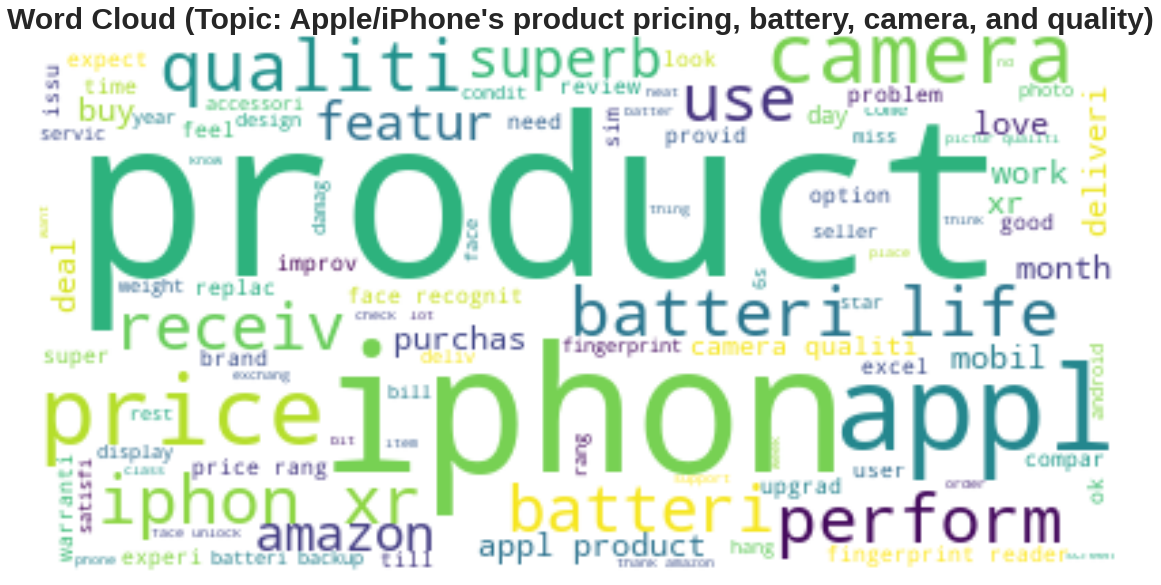

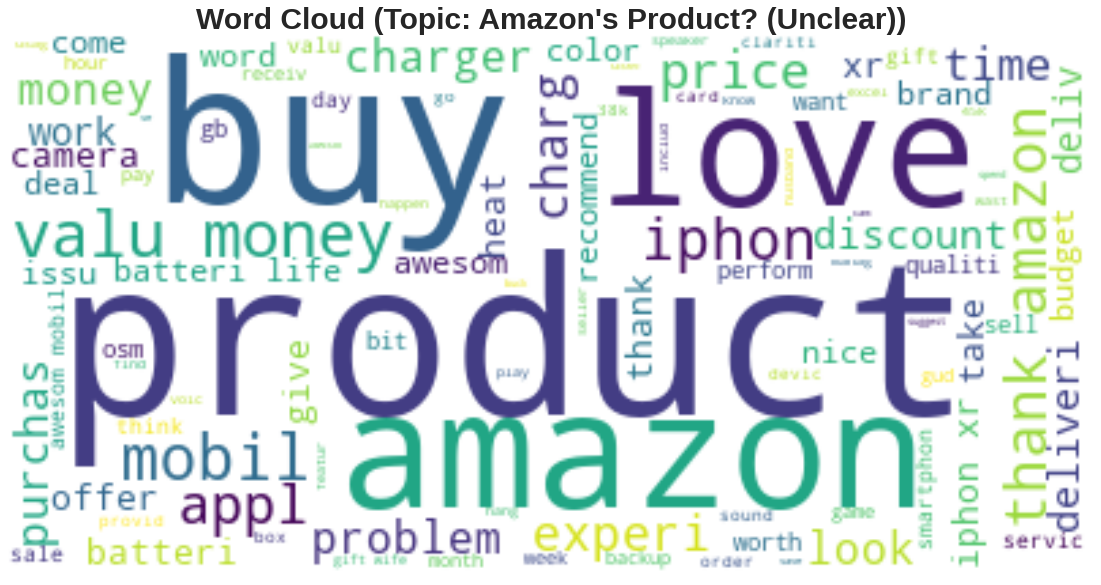

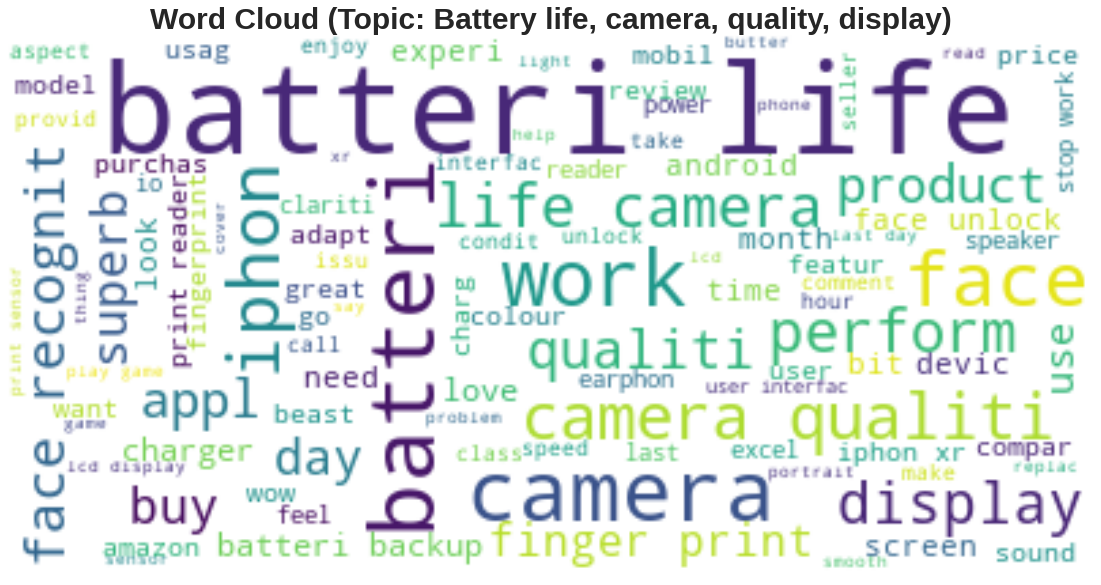

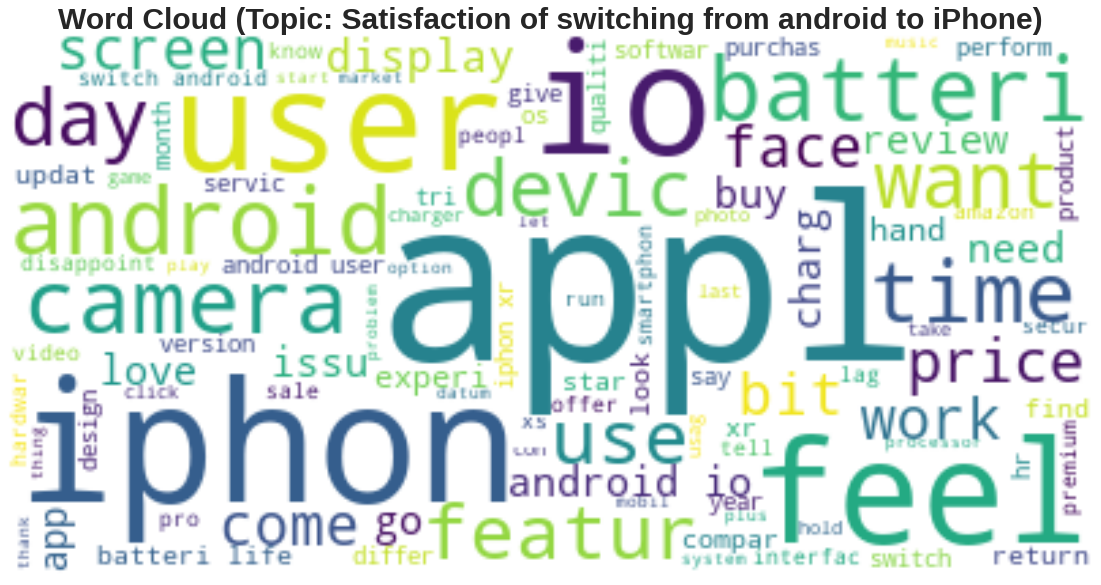

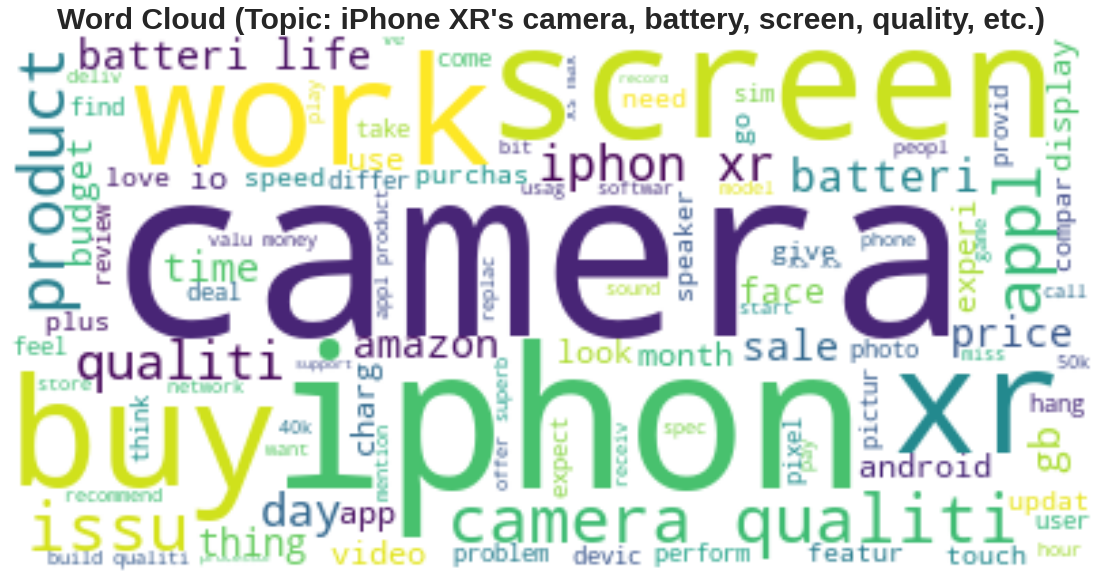

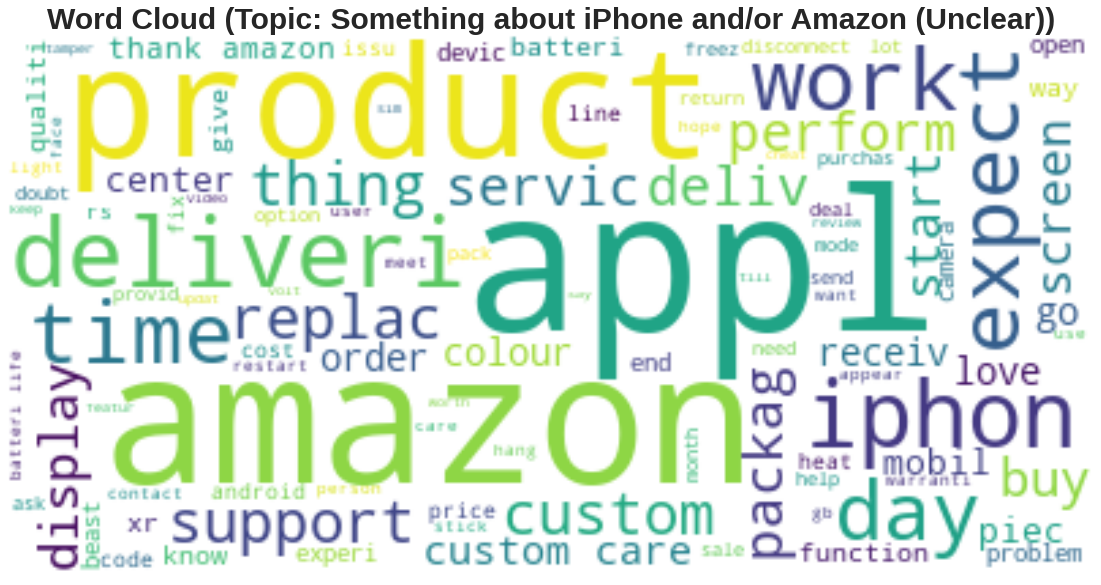

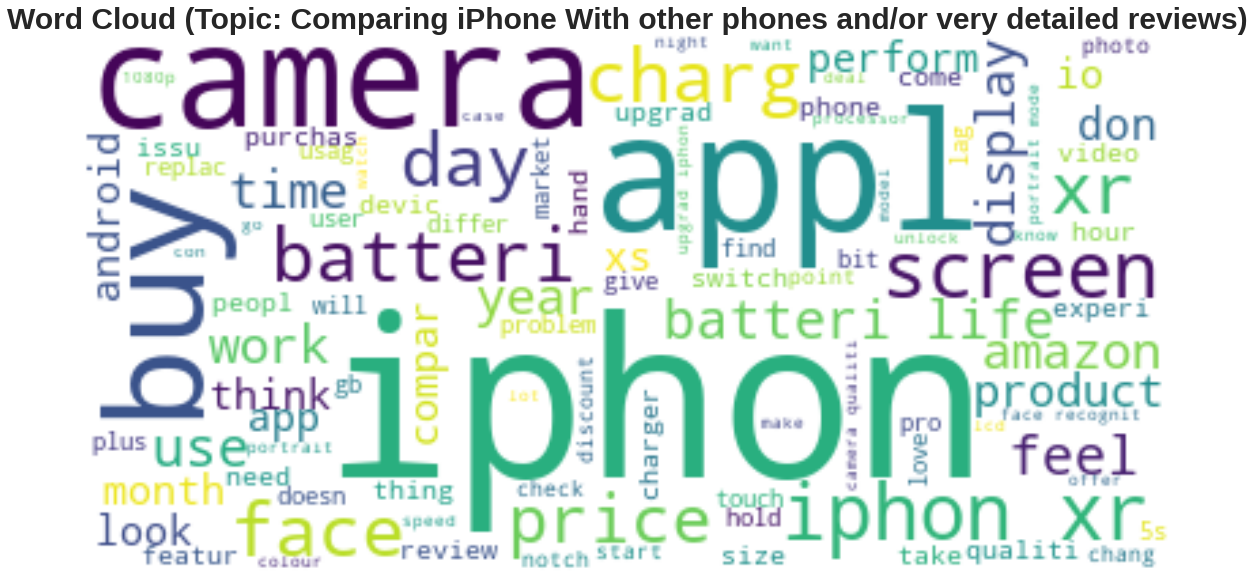

In [51]:
lda_model.generate_topic_word_cloud(topic_names=list(topics.keys()))

In [52]:
df['topic_index'] = lda_model.training_samples_prediction_
df['topic_names'] = df['topic_index'].apply(lambda x: topic_names[x])
df.head()

title       date location  \
0  Which iPhone you should Purchase ? iPhone 8, X... 2018-12-12    India   
1                   Don't buy iPhone xr from Amazon. 2018-11-17    India   
2                            Happy with the purchase 2019-01-27    India   
3  Amazon is not an apple authorised reseller. Pl... 2019-05-02    India   
4       Excellent Battery life and buttery smooth UI 2019-05-24    India   

   rating                                               text  \
0     3.0  NOTE:@ This is detailed comparison between iPh...   
1     1.0  Very bad experience with this iPhone xr phone....   
2     5.0  Amazing phone with amazing camera coming from ...   
3     1.0  So I got the iPhone XR just today. The product...   
4     5.0  I've been an android user all my life until I ...   

                     title_clean  \
0  iphon purchas iphon 8 x xs xr   
1      don t buy iphon xr amazon   
2                        purchas   
3         amazon appl resel note   
4  excel batteri life butteri ui   

                                          text_clean  topic_index  \
0  note comparison iphon 8 x xs xr month state ba...            6   
1  experi iphon xr camera find amazon haven t get...            4   
2             camera come iphon 7 plus servic amazon            4   
3  get iphon xr today product look face d work gl...            4   
4  ve android user life decid tri iphon xr io lov...            4   

                                         topic_names  
0  Comparing iPhone With other phones and/or very...  
1  iPhone XR's camera, battery, screen, quality, ...  
2  iPhone XR's camera, battery, screen, quality, ...  
3  iPhone XR's camera, battery, screen, quality, ...  
4  iPhone XR's camera, battery, screen, quality, ...

In [53]:
for name in topic_names:
    print('topic:', name)
    print('keywords:', topics[name])
    print('sample texts:')
    for i, text in enumerate(df[df['topic_names'] == name].sample(10)['text']):
        print(f'{i+1}. {text}\n')
    print('*****\n')

topic: Apple/iPhone's product pricing, battery, camera, and quality
keywords: "product", "iphon", "appl", "price", "batteri", "camera", "qualiti", "xr", "life", "superb"
sample texts:
1. It’s a very awesome mobile. Overall it’s really good. Hats off to apple that they provide these kinda of awesome products.

2. Overall its a good product, battery backup is little bit good compared to other iphone models.., Camera is Okay but i have seen mostly noise in the photos.Sound quality is as usual awesome, and I didn’t tried underwater test but tried splash test, it’s up to the mark upon splash proof....I am using it since last 3 months I didn’t face any problem...Go 4 It👍🏻

3. So superb .. I’m 1st time using iPhone . Very interesting nd I’m impressed .. camera quality awesome . 1day battery backup .. face lock in very strong ..

4. The product is really good

5. Very happy with the received product. No issues whatsoever till date.

6. This product is not adequate in terms of its quality & per

In [55]:
dates = []
topics_count = []
unique_dates = np.unique(df['date'].sort_values())


for date in unique_dates:
    dates.append(date)
    topics = df.loc[df['date']==date, 'topic_index']
    if type(topics)==np.float32:
        topics = [topics]
    count = np.zeros(len(np.unique(df['topic_index'])), np.uint32)
    for idx in topics:
        count[idx] += 1
    topics_count.append(count)
    
# y = list(map(str, np.unique(df['topic_index'])))
y = list(np.unique(df['topic_names']))
df_ratings = pd.DataFrame(topics_count, dates, columns = y).resample('W').sum().reset_index()
df_ratings.columns = ['period', *y]
z = df_ratings['period'].copy()
df_ratings['period'] = df_ratings['period'].map(lambda x: str(x)[:10] + ' - ' + str(pd.offsets.DateOffset(6) + x)[:10])
df_ratings.head()

period  Amazon's Product? (Unclear)  \
0  2018-11-04 - 2018-11-10                            1   
1  2018-11-11 - 2018-11-17                            0   
2  2018-11-18 - 2018-11-24                            0   
3  2018-11-25 - 2018-12-01                            0   
4  2018-12-02 - 2018-12-08                            0   

   Apple/iPhone's product pricing, battery, camera, and quality  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  1              

   Battery life, camera, quality, display  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       1   

   Comparing iPhone With other phones and/or very detailed reviews  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   Satisfaction of switching from android to iPhone  \
0                                                 0   
1                                                 0   
2                                                 2   
3                                                 1   
4                                                 0   

   Something about iPhone and/or Amazon (Unclear)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   iPhone XR's camera, battery, screen, quality, etc.  
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  1   
4                                                  1

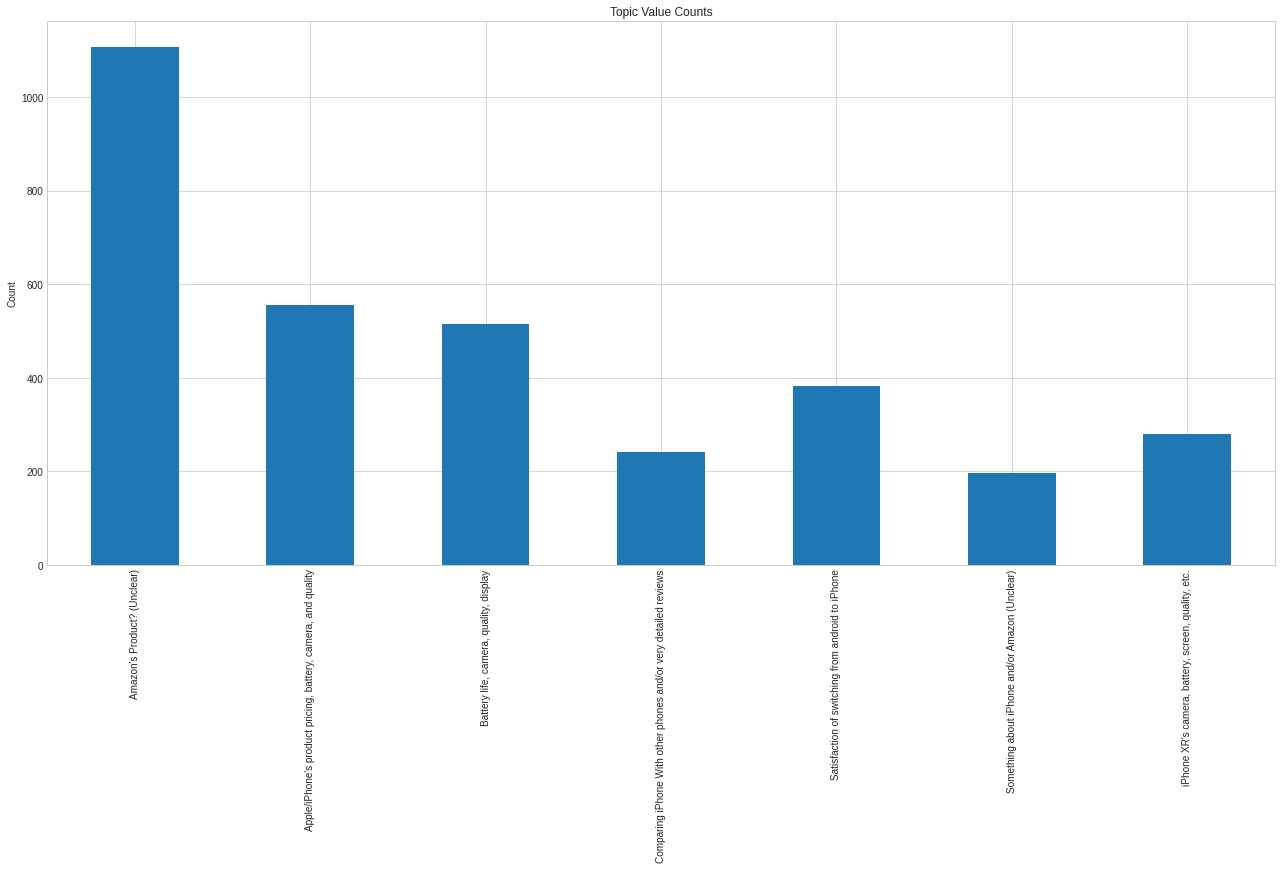

In [56]:
_ = df_ratings.iloc[:, 1:].sum().plot.bar(ylabel='Count', title='Topic Value Counts')

In [60]:
ticks = [
    ['End of Q4 2018', (2019,1,1)], 
    *[[f'End of Q{i+1} 2019', (2019 if i < 3 else 2020, 4+i*3 if i < 3 else 1, 1)] for i in range(4)], 
    *[[f'End of Q{i+1} 2020', (2020, 4+i*3 , 1)] for i in range(2)], 
]

ticktext, tickvals = [], []
for i in ticks:
    idx = np.where(z > pd.Timestamp(*i[1]))[0][0] - 1
    ticktext.append(i[0])
    tickvals.append(df_ratings['period'][idx])
    
# Generate figure
fig = px.line(df_ratings, x='period', y=y)

# Update plot title, legend, and barmode
fig.update_layout(
    title=dict(text='Product Review Count', x=0.5),
    legend=dict(
        title_text="Review Category",
#         orientation="h",
#         yanchor="bottom",
#         y=1.0,
#         xanchor="right",
#         x=1.0
    ),
    barmode='stack'
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
#     rangeslider_visible=True,
)

# Update y-axis
fig.update_yaxes(title_text='Count')

fig.show()